In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive

c:\Users\MNIS\Anaconda3\envs\ModelBasedML38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Processing

In [2]:
scaler = StandardScaler()

In [3]:
#Use your own local path please!
path = "./Data/"
file_name = ["train.csv", "test.csv", "submission.csv"]
df_train = pd.read_csv(path + file_name[0])
df_test = pd.read_csv(path + file_name[1])
df_submission = pd.read_csv(path + file_name[2])

In [4]:
df_train['key'] = df_train['key'].fillna(df_train['key'].mean())

In [5]:
df_train['instrumentalness'] = df_train['instrumentalness'].fillna(df_train['instrumentalness'].mean())

In [6]:
df_train['Popularity'] = df_train['Popularity'].fillna(df_train['Popularity'].mean())

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
df_features = df_train[['Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature']].copy()
df_features[df_features.columns] = scaler.fit_transform(df_features)

df_train_target = df_train[['Class']].sample(1000)
df_train_target_index = df_train_target.index
df_train_features = df_features.iloc[df_train_target_index].to_numpy()
df_train_target = df_train_target.to_numpy()

df_features_new = df_features
df_features_new[['Class']] = df_train[['Class']]
# df_features_new

df_rest_features = df_features_new.drop(index = df_train_target_index).reset_index()
# df_rest_target = df_train_target.iloc[~df_train_target_index].reset_index()
df_rest_features = df_rest_features.drop(columns = {df_rest_features.columns[0]})
df_test_target = df_rest_features[['Class']].sample(200)
df_test_target_index = df_test_target.index

df_test_features = df_rest_features.iloc[df_test_target_index]
df_test_features = df_test_features.drop(columns={'Class'}).to_numpy()

df_test_target = df_test_target.to_numpy()


# df_rest_features

In [9]:
df_rest_02 = df_rest_features.drop(index = df_test_target_index).reset_index()
df_rest_02 = df_rest_02.drop(columns = {df_rest_02.columns[0]})
df_val_target = df_rest_02[['Class']].sample(200)
df_val_target_index = df_val_target.index

df_val_features = df_rest_02.iloc[df_val_target_index]
df_val_features = df_val_features.drop(columns={'Class'}).to_numpy()

df_val_target = df_val_target.to_numpy()
df_val_features.shape, df_val_target.shape

((200, 14), (200, 1))

In [10]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
N_val = df_val_features.shape[0]
n_cat = 11 
degF=5
tau=10

### Ancestral Sampling 

In [11]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [-0.09108397  0.06471002 -0.64184945  2.10179848 -0.24270975  0.28414784
 -1.46681177  1.3736116   0.17179792 -0.36771408  0.05778779  0.92901871
 -0.74143262 -0.66589437]


In [12]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))


In [13]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({4.0: 199,
         7.0: 58,
         0.0: 79,
         9.0: 142,
         1.0: 77,
         2.0: 61,
         5.0: 76,
         3.0: 24,
         10.0: 143,
         8.0: 101,
         6.0: 40})

In [14]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.098


In [17]:
df_train_features.shape

(1000, 14)

### Model implementation with Pyro

In [21]:
def model(X, n_cat, degF, tau, obs=None):
    
    input_dim = X.shape[1]
    
    mu_beta = pyro.sample("mu_beta", dist.StudentT(df=torch.ones(n_cat)*degF, 
                                                    loc=torch.zeros(n_cat), 
                                                    scale=torch.ones(n_cat)).to_event()) # Prior for the bias mean      
    
    with pyro.plate("ARD", input_dim):

        sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
        
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [22]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Parameter Tuning

##### Degree of Freedom

In [40]:
degF_range = [4,5,6]

acc_val_degF = []


for degF in degF_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 20000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    
    print({degF:acc})
    acc_val_degF.append({degF:acc})
   

[0] ELBO: 5402.8
[1000] ELBO: 2227.7
[2000] ELBO: 1870.2
[3000] ELBO: 1710.5
[4000] ELBO: 1670.2
[5000] ELBO: 1647.9
[6000] ELBO: 1631.9
[7000] ELBO: 1637.6
[8000] ELBO: 1631.7
[9000] ELBO: 1629.7
[10000] ELBO: 1632.5
[11000] ELBO: 1622.3
[12000] ELBO: 1635.6
[13000] ELBO: 1634.5
[14000] ELBO: 1620.6
[15000] ELBO: 1607.3
[16000] ELBO: 1595.6
[17000] ELBO: 1616.3
[18000] ELBO: 1606.9
[19000] ELBO: 1624.9
{4: 0.46}
[0] ELBO: 5297.8
[1000] ELBO: 2121.6
[2000] ELBO: 1759.0
[3000] ELBO: 1701.1
[4000] ELBO: 1653.3
[5000] ELBO: 1659.4
[6000] ELBO: 1650.1
[7000] ELBO: 1645.2
[8000] ELBO: 1621.0
[9000] ELBO: 1633.8
[10000] ELBO: 1625.0
[11000] ELBO: 1613.0
[12000] ELBO: 1648.4
[13000] ELBO: 1646.9
[14000] ELBO: 1625.9
[15000] ELBO: 1608.7
[16000] ELBO: 1615.7
[17000] ELBO: 1643.3
[18000] ELBO: 1681.7
[19000] ELBO: 1598.9
{5: 0.46}
[0] ELBO: 6588.5
[1000] ELBO: 2352.0
[2000] ELBO: 1812.9
[3000] ELBO: 1695.1
[4000] ELBO: 1665.9
[5000] ELBO: 1643.8
[6000] ELBO: 1640.5
[7000] ELBO: 1640.7
[8000] EL

In [41]:
acc_val_degF

[{4: 0.46}, {5: 0.46}, {6: 0.46}]

##### Tau in Variance

In [42]:
tau_range = [1,10,50,100]

acc_val_tau = []


for tau in tau_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 20000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    print({tau:acc})
    acc_val_tau.append({tau:acc})
   

[0] ELBO: 4916.5
[1000] ELBO: 2113.6
[2000] ELBO: 1732.0
[3000] ELBO: 1682.6
[4000] ELBO: 1659.4
[5000] ELBO: 1638.0
[6000] ELBO: 1630.8
[7000] ELBO: 1613.9
[8000] ELBO: 1606.2
[9000] ELBO: 1641.7
[10000] ELBO: 1631.7
[11000] ELBO: 1645.6
[12000] ELBO: 1603.7
[13000] ELBO: 1616.2
[14000] ELBO: 1615.6
[15000] ELBO: 1613.0
[16000] ELBO: 1609.6
[17000] ELBO: 1607.9
[18000] ELBO: 1632.5
[19000] ELBO: 1631.4
{1: 0.465}
[0] ELBO: 22980.0
[1000] ELBO: 16495.4
[2000] ELBO: 11299.6
[3000] ELBO: 7772.6
[4000] ELBO: 5614.2
[5000] ELBO: 4549.5
[6000] ELBO: 3157.1
[7000] ELBO: 2537.6
[8000] ELBO: 2292.8
[9000] ELBO: 2039.3
[10000] ELBO: 2009.6
[11000] ELBO: 1901.7
[12000] ELBO: 1892.6
[13000] ELBO: 1828.3
[14000] ELBO: 1879.8
[15000] ELBO: 1835.5
[16000] ELBO: 1816.7
[17000] ELBO: 1818.2
[18000] ELBO: 1839.5
[19000] ELBO: 1820.6
{10: 0.455}
[0] ELBO: 95932.4
[1000] ELBO: 88319.0
[2000] ELBO: 80205.6
[3000] ELBO: 73749.5
[4000] ELBO: 68970.9
[5000] ELBO: 63500.4
[6000] ELBO: 56186.1
[7000] ELBO: 540

In [43]:
acc_val_tau

[{1: 0.465}, {10: 0.455}, {50: 0.335}, {100: 0.115}]

#### Final Model training 

In [44]:
degF=5
tau=1

In [45]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 4813.1
[1000] ELBO: 2012.4
[2000] ELBO: 1737.6
[3000] ELBO: 1670.0
[4000] ELBO: 1658.9
[5000] ELBO: 1650.9
[6000] ELBO: 1634.6
[7000] ELBO: 1618.2
[8000] ELBO: 1617.3
[9000] ELBO: 1611.5


In [46]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

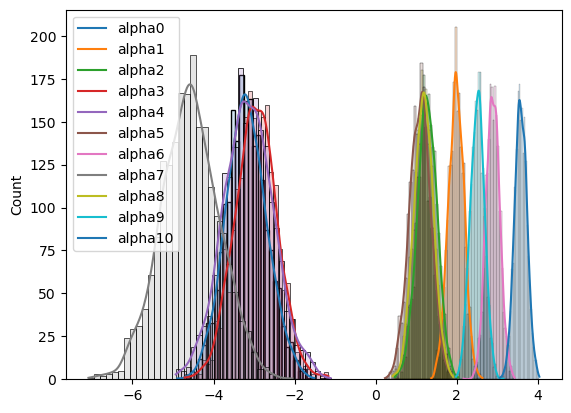

In [47]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

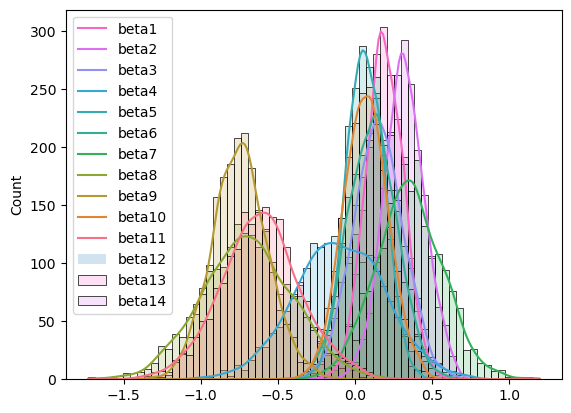

In [48]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [49]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

### Inference and computation of accuracy on the train dataset 

In [56]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [57]:
y_train_pred = y_train_pred[:,0]

In [58]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.538


### Inference and computation of accuracy on the test dataset 

In [59]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [60]:
y_test_pred = y_test_pred[:,0]

In [61]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.475



DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 
* Consider different distributions for priors

Done

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Train model on more data - currently 100 

TODO

* Feature engineer name and album name and retrain logistic regression model using these attributes
* Hyper parameter tuning
* Extend it with FFNN 
* Train model on more data (like 10000)